In [1]:
import sys, os
import torch
from torch import Tensor
from torch.utils.data import DataLoader, random_split
from trajdata import AgentBatch, UnifiedDataset

sys.path.append(os.path.abspath("../"))
from src.data.batch_proccessing import make_model_collate
from src.models.ode_ctx import ODEBaselineCtx    
from torch import nn
from tqdm import tqdm
import pytorch_lightning as pl
import matplotlib.pyplot as plt
pl.seed_everything(42)

/home/g.devchich/sk_msd_trajectoryFM/.venv/lib/python3.10/site-packages/lightning_utilities/core/imports.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Global seed set to 42


42

In [2]:
dataset = UnifiedDataset(
        desired_data=["eupeds_eth","eupeds_hotel","eupeds_univ","eupeds_zara1","eupeds_zara2"],
        data_dirs={
            "eupeds_eth":  "../data/eth",
            "eupeds_hotel":"../data/eth",
            "eupeds_univ": "../data/eth",
            "eupeds_zara1":"../data/eth",
            "eupeds_zara2":"../data/eth",
        },
        desired_dt=0.1,
        state_format='x,y',
        obs_format='x,y',
        centric="scene",
        history_sec=(0.8,0.8),
        future_sec=(0.8,0.8),
        standardize_data=False,
    )
collate_fn = make_model_collate(dataset=dataset, memory=4, dim=2)

In [ ]:
# @torch.no_grad()
# def ade_fde(pred, gt):  # pred, gt: (F,N,2)
#     d = torch.linalg.norm(pred - gt, dim=-1)  # (F,N)
#     return d.mean().item(), d[-1].mean().item()

In [3]:
N = len(dataset)
n_eval = max(1, int(0.05 * N))
_, eval_ds = random_split(dataset, [N - n_eval, n_eval], generator=torch.Generator().manual_seed(42))

eval_loader = DataLoader(eval_ds, batch_size=64, shuffle=False,
                             num_workers=0, pin_memory=True,
                             collate_fn=collate_fn)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
model = ODEBaselineCtx(dim=2, hist_len=4, w=384, ctx_dim=32, nblocks=3).to(device)
model.load_state_dict(torch.load("../src/ode_ctx_best.pth", map_location=device))
model.eval()

ODEBaselineCtx(
  (func): ODEFuncCtx(
    (ctx_mlp): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): SiLU()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (3): Linear(in_features=128, out_features=32, bias=True)
      (4): SiLU()
    )
    (inp): Sequential(
      (0): Linear(in_features=35, out_features=384, bias=True)
      (1): SiLU()
      (2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
    (blocks): Sequential(
      (0): ResBlock(
        (f): Sequential(
          (0): Linear(in_features=384, out_features=384, bias=True)
          (1): SiLU()
          (2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (3): Linear(in_features=384, out_features=384, bias=True)
        )
      )
      (1): ResBlock(
        (f): Sequential(
          (0): Linear(in_features=384, out_features=384, bias=True)
          (1): SiLU()
          (2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      

In [10]:
F = 8
Ks = torch.tensor([1, 2, 4, F], device=device)
USE_SCALE = False
criterion = nn.MSELoss() 
SCALE_S = 100.0 

In [11]:
def ade_fde(pred_F_N_2: torch.Tensor, gt_N_F_2: torch.Tensor):
    # pred: (F,N,2), gt: (N,F,2)
    diff = pred_F_N_2 - gt_N_F_2.permute(1,0,2)
    l2 = torch.linalg.norm(diff, dim=-1)  # (F,N)
    ade = l2.mean().item()
    fde = l2[-1].mean().item()
    return ade, fde

In [12]:
val_loss = 0.0
seen = 0
sum_ade, sum_fde, batches = 0.0, 0.0, 0
with torch.no_grad():
        for batch in tqdm(eval_loader, desc=f"[val]"):
            if batch is None:
                continue
            x0, x0_class, x1_full, x1_next, t0, t1 = batch
            x0, x0_class, x1_full, t1 = x0.to(device), x0_class.to(device), x1_full.to(device), t1.to(device)
            dt = t1[0].to(x0.dtype)

            if USE_SCALE:
                x0_s = x0 * SCALE_S
                x1_full_s = x1_full * SCALE_S
            else:
                x0_s = x0
                x1_full_s = x1_full

            # лосс на тех же Ks
            vloss = 0.0
            for k in Ks:
                pred_k = model(x0_s, dt*k, x0_class)
                tgt_k  = x1_full_s[:, int(k.item())-1, :]
                vloss += criterion(pred_k, tgt_k)
            vloss /= len(Ks)

            # ADE/FDE на полном горизонте
            pred_full = model.predict_horizons(x0_s, x0_class, dt=float(dt.item()), F=F)  # (F,N,2)
            # если скалировали на входе — вернём масштаб для метрик
            if USE_SCALE:
                pred_full = pred_full / SCALE_S

            ade, fde = ade_fde(pred_full, x1_full)
            sum_ade += ade
            sum_fde += fde
            batches += 1

            bs = x0.size(0)
            val_loss += vloss.item() * bs
            seen += bs

val_loss /= max(1, seen)
mean_ade = sum_ade / max(1, batches)
mean_fde = sum_fde / max(1, batches)

print(f"val_loss={val_loss:.6f}  ADE={mean_ade:.6f}  FDE={mean_fde:.6f}")


[val]: 100%|██████████| 109/109 [03:30<00:00,  1.93s/it]

val_loss=0.003261  ADE=0.055681  FDE=0.104114


In [13]:
@torch.no_grad()
def plot_gt_vs_pred_from_batch(
    model, batch, rows=4, cols=4, shared_limits=True,
    seed=0xDEADBEEF, rtol=1e-6, atol=1e-9, min_span=0.5, pad_ratio=0.15
):
    # unpack
    x0, x0_class, x1_full, x1_next, t0, t1 = batch
    device = next(model.parameters()).device
    x0, x0_class, x1_full, t1 = x0.to(device), x0_class.to(device), x1_full.to(device), t1.to(device)

    N, F = x0.size(0), x1_full.size(1)
    dt = float(t1[0].to(x0.dtype).item())

    # predict: (F,N,2)
    pred_F_N_2 = model.predict_horizons(x0, x0_class, dt=dt, F=F, rtol=rtol, atol=atol)

    # move to CPU
    x0_cpu       = x0.detach().cpu()
    x0cls_cpu    = x0_class.detach().cpu()
    gt_N_F_2     = x1_full.detach().cpu()          # (N,F,2)
    pred_N_F_2   = pred_F_N_2.permute(1,0,2).cpu() # (N,F,2)

    M = x0cls_cpu.size(1) // 2
    K = min(rows*cols, N)
    idxs = torch.randperm(N, generator=torch.Generator().manual_seed(seed))[:K].tolist()

    # shared limits
    glx = gly = None
    if shared_limits:
        all_pts = []
        for i in idxs:
            hist = x0cls_cpu[i].reshape(M,2)
            all_pts.append(torch.vstack([hist, x0_cpu[i:i+1], gt_N_F_2[i], pred_N_F_2[i]]))
        pts = torch.vstack(all_pts)
        x_min, y_min = pts.min(0).values.tolist()
        x_max, y_max = pts.max(0).values.tolist()
        span = max(x_max - x_min, y_max - y_min, min_span) * (1+pad_ratio)
        cx, cy = (x_min+x_max)/2, (y_min+y_max)/2
        glx, gly = (cx-span/2, cx+span/2), (cy-span/2, cy+span/2)

    # draw
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten()
    for ax, i in zip(axes, idxs):
        hist = x0cls_cpu[i].reshape(M,2)
        x0i  = x0_cpu[i]
        gti  = gt_N_F_2[i]
        pri  = pred_N_F_2[i]

        if M>0: ax.plot(hist[:,0], hist[:,1], '-', lw=1, marker='o', ms=2, label='history')
        ax.scatter(x0i[0].item(), x0i[1].item(), s=25, label='x0')
        ax.plot(gti[:,0], gti[:,1], '--', lw=1.5, marker='x', ms=3, label='GT')
        ax.plot(pri[:,0], pri[:,1], '-',  lw=1.8, marker='o', ms=3, label='Pred')

        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f"id={i}", fontsize=9)
        ax.grid(True); ax.set_xlabel("x", fontsize=8); ax.set_ylabel("y", fontsize=8)
        if glx: ax.set_xlim(*glx); ax.set_ylim(*gly)
        else:
            pts = torch.vstack([hist, x0i.unsqueeze(0), gti, pri])
            xmin,ymin = pts.min(0).values.tolist(); xmax,ymax = pts.max(0).values.tolist()
            span = max(xmax-xmin, ymax-ymin, min_span)*(1+pad_ratio)
            cx,cy = (xmin+xmax)/2, (ymin+ymax)/2
            ax.set_xlim(cx-span/2, cx+span/2); ax.set_ylim(cy-span/2, cy+span/2)

    for j in range(K, rows*cols): fig.delaxes(axes[j])
    handles, labels = axes[0].get_legend_handles_labels()
    if handles: fig.legend(handles, labels, loc='upper right', fontsize=9)
    fig.suptitle(f"{rows}×{cols} GT vs Pred (F={F}, dt={dt:.2f})", fontsize=14)
    fig.tight_layout()
    plt.show()

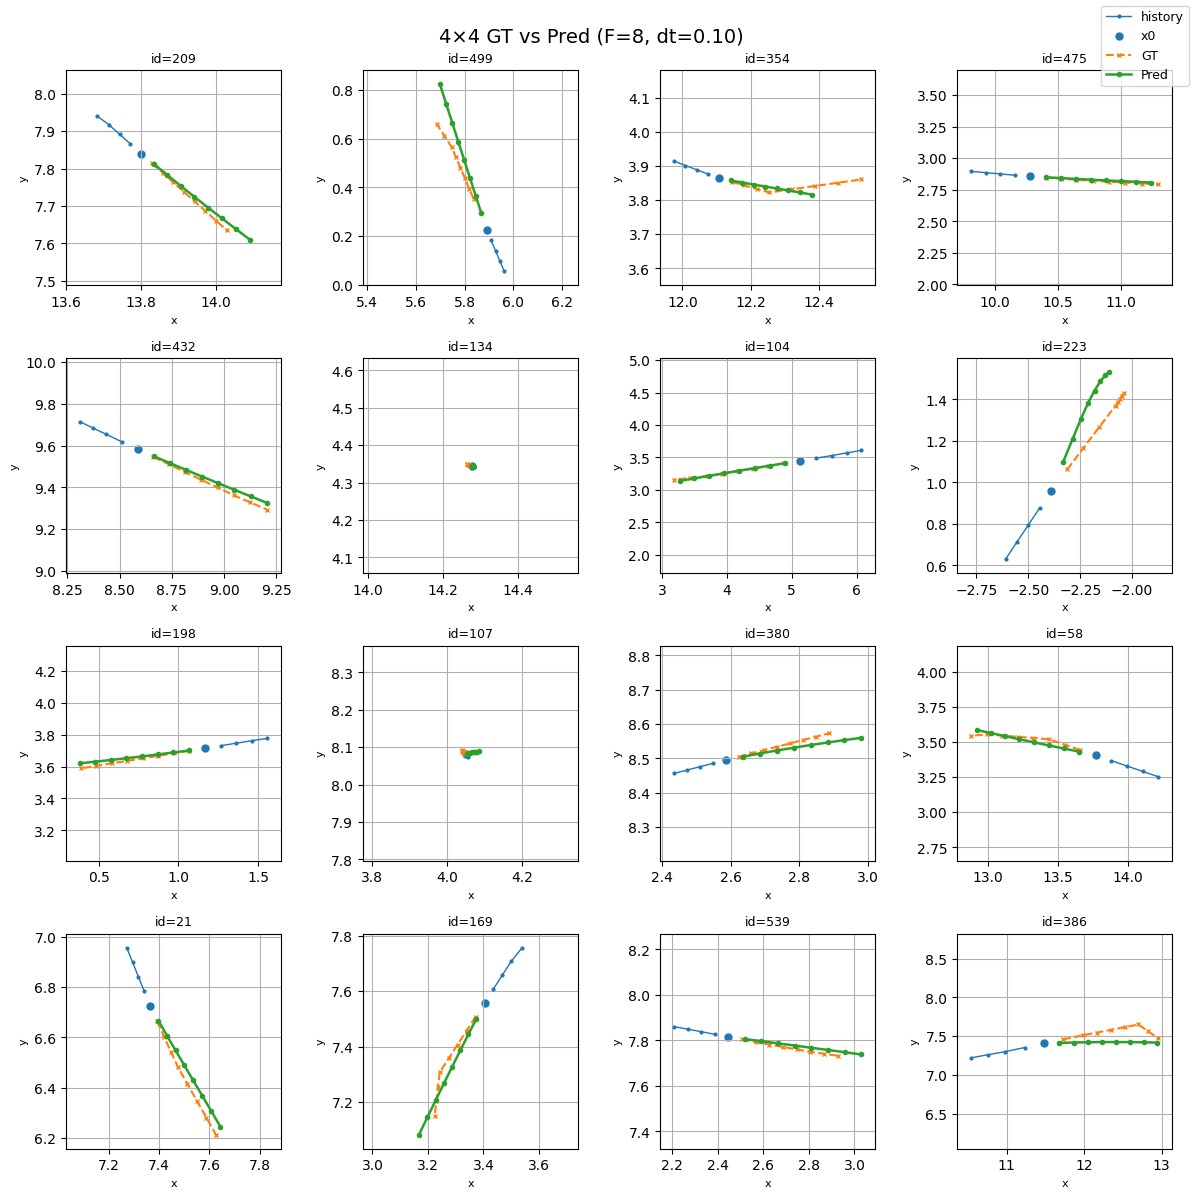

In [14]:
_ = plot_gt_vs_pred_from_batch(model, batch, rows=4, cols=4, shared_limits=False)